In [1]:
from typing import Tuple
import copy
import numpy as np
from matplotlib import pyplot as plt
from src.envs import NoThreeCollinearEnv, Point, NoThreeCollinearEnvWithPriority, FastNoThreeCollinearEnv


## Symmetry search

In [4]:
def symmetry(point: Point, grid_shape):
    # we actually assume that the grid shape is n*n instead
    m, n = grid_shape
    equiv_classes = {point}
    equiv_classes.update([Point(n-1-point.x, point.y), Point(point.x, n-1-point.y), Point(n-1-point.x, n-1-point.y)])
    return equiv_classes

def is_subset(A, B):
    set_A = set(map(tuple, A))
    set_B = set(map(tuple, B))
    return set_A.issubset(set_B)

best_score = -np.inf
best_points = None

def dfs(env, symmetry_fn):
    global best_score, best_points
    m, n = env.grid_shape
    if len(env.points) > best_score:
        best_score = len(env.points)
        best_points = env.points

    choices = np.argwhere(env.priority_map != -np.inf)
    # If there are no more points that we can select. We reach the leaf node, and update the best_score and best_points
    if len(choices)==0:
        return

    # pruning process
    if len(choices) <= best_score - len(env.points):
        return

    for point in choices:
        if point[1].item() <= (n-1) // 2 and point[0].item() <= (n-1) // 2:
            equiv_classes = symmetry_fn(Point(point[1].item(), point[0].item()), env.grid_shape)
            # if is_subset(equiv_classes, choices[:, [1,0]]):
            #     new_env = copy.deepcopy(env)
            #     for p in equiv_classes:
            #         new_env.add_point(p)
            #     dfs(new_env, symmetry_fn)


            # print(equiv_classes)
            new_env = copy.deepcopy(env)
            for p in equiv_classes:
                terminated, _ = new_env.add_point(p)
                # if we terminate at one step of trying to add points, we record the result, and return
                if terminated:
                    return
            dfs(new_env, symmetry_fn)


env = NoThreeCollinearEnvWithPriority(11,11)

dfs(env,symmetry)
print(best_points)
print(best_score)

[Point(x=1, y=0), Point(x=9, y=0), Point(x=9, y=10), Point(x=1, y=10), Point(x=4, y=9), Point(x=6, y=1), Point(x=4, y=1), Point(x=6, y=9), Point(x=0, y=2), Point(x=10, y=8), Point(x=10, y=2), Point(x=0, y=8), Point(x=3, y=7), Point(x=3, y=3), Point(x=7, y=7), Point(x=7, y=3), Point(x=2, y=4), Point(x=8, y=4), Point(x=2, y=6), Point(x=8, y=6)]
20


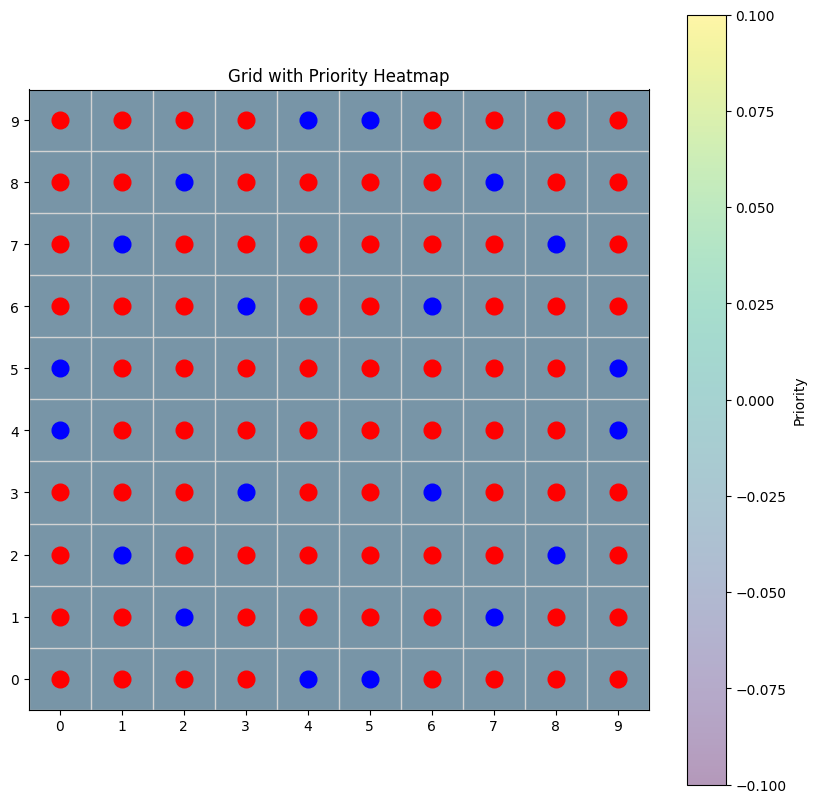

In [3]:
env.reset()
for point in best_points:
    env.self_play_add_point(point, plot=False)
env.plot()

## Exhaustive dfs with equiv class pruning. (Equiv class modding $D_8$, and permutation of points)

In [ ]:
import copy
from collections import namedtuple
import numpy as np

# Assuming your NoThreeCollinearEnv and Point are already imported
# from your environment module.


def diagonal_symmetry_fn(points, grid_shape):
    """
    For diagonal reflection symmetry over y=x.
    We normalize the set of points by sorting both original and reflected,
    and pick the lex smallest as the canonical representative.
    """
    reflected_points = [Point(p.y, p.x) for p in points]
    canonical = min(
        tuple(sorted((p.x, p.y) for p in points)),
        tuple(sorted((p.x, p.y) for p in reflected_points))
    )
    return canonical

def dihedral_symmetry_fn(points, grid_shape):
    """
    Returns the canonical form under full dihedral symmetry (8 symmetries of the square).
    """
    n = grid_shape[0]
    point_set = np.array([[p.x, p.y] for p in points], dtype=int)

    transforms = []

    for rot in range(4):
        # Rotate
        rotated = point_set.copy()
        for _ in range(rot):
            rotated = np.column_stack([n-1-rotated[:,1], rotated[:,0]])
        transforms.append(tuple(sorted(map(tuple, rotated))))

        # Reflect over y-axis after rotation
        reflected_y = rotated.copy()
        reflected_y[:,0] = n-1 - reflected_y[:,0]
        transforms.append(tuple(sorted(map(tuple, reflected_y))))

    # Return the lex smallest
    return min(transforms)

def diagonal_symmetry_fn_legacy(points, grid_shape):
    """
    Emulate the legacy C symmetry: normalize under reflections over
    both diagonals (y=x and y=-x).
    """
    n = grid_shape[0]
    point_set = np.array([[p.x, p.y] for p in points], dtype=int)

    transforms = []

    # Identity
    transforms.append(tuple(sorted(map(tuple, point_set))))

    # Reflect over y = x
    diag1 = np.column_stack([point_set[:,1], point_set[:,0]])
    transforms.append(tuple(sorted(map(tuple, diag1))))

    # Reflect over y = -x
    diag2 = np.column_stack([n-1 - point_set[:,1], n-1 - point_set[:,0]])
    transforms.append(tuple(sorted(map(tuple, diag2))))

    # Compose both reflections (same as rotation by 180 + reflection)
    diag_both = np.column_stack([n-1 - point_set[:,0], n-1 - point_set[:,1]])
    transforms.append(tuple(sorted(map(tuple, diag_both))))

    return min(transforms)

def full_dihedral_symmetry_fn(points, grid_shape):
    """
    Normalize the set of points under the full dihedral group of the square (D8),
    which includes all rotations (0,90,180,270) and reflections.

    Returns a canonical tuple of points for symmetry pruning.
    """
    n = grid_shape[0]
    point_set = np.array([[p.x, p.y] for p in points], dtype=int)
    transforms = []

    # Identity
    transforms.append(tuple(sorted(map(tuple, point_set))))

    # Rotate 90,180,270
    rotated = point_set.copy()
    for _ in range(1, 4):
        rotated = np.column_stack([n-1 - rotated[:,1], rotated[:,0]])
        transforms.append(tuple(sorted(map(tuple, rotated))))

    # Reflect over vertical
    reflected_v = point_set.copy()
    reflected_v[:,0] = n-1 - reflected_v[:,0]
    transforms.append(tuple(sorted(map(tuple, reflected_v))))

    # Reflect over horizontal
    reflected_h = point_set.copy()
    reflected_h[:,1] = n-1 - reflected_h[:,1]
    transforms.append(tuple(sorted(map(tuple, reflected_h))))

    # Reflect over main diagonal (y=x)
    reflected_d1 = np.column_stack([point_set[:,1], point_set[:,0]])
    transforms.append(tuple(sorted(map(tuple, reflected_d1))))

    # Reflect over other diagonal (y=-x)
    reflected_d2 = np.column_stack([n-1 - point_set[:,1], n-1 - point_set[:,0]])
    transforms.append(tuple(sorted(map(tuple, reflected_d2))))

    # Compose both: reflect y=x then rotate by 180 (for coverage)
    reflected_d1_rot180 = np.column_stack([n-1 - reflected_d1[:,0], n-1 - reflected_d1[:,1]])
    transforms.append(tuple(sorted(map(tuple, reflected_d1_rot180))))

    return min(transforms)

def dfs(env, seen, symmetry_fn, max_depth):
    if len(env.points) >= max_depth:
        print("Found solution with", len(env.points), "points:", env.points)
        return

    choices = np.argwhere(env.priority_map != -np.inf)
    if len(choices) == 0:
        return

    for point in choices:
        p = Point(point[1].item(), point[0].item())
        cannon = symmetry_fn(env.points + [p], env.grid_shape)
        if cannon not in seen:
            seen.add(cannon)
            new_env = copy.deepcopy(env)
            new_env.add_point(p)
            dfs(new_env, seen, symmetry_fn, max_depth)

n = 5
env = NoThreeCollinearEnvWithPriority(n, n)
seen = set()
dfs(env, seen, full_dihedral_symmetry_fn, max_depth=2*n)
print(f"searched for {len(seen)} cases")

In [24]:
print(len(seen))

451719


For n = 5

Old computation speed = 37s

less call to reduced slope = 35s

new computation speed (Fast No THREE ENV) = 25s

priority function style computation speed = 24s

priority function with only valid action = 5s

For n = 6, this is already huge (4m check), with 451719 cases